In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

c:\Users\saxen\anaconda3\lib\site-packages\huggingface_hub\utils\_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
def show_img(image_batch):
    grid = make_grid(image_batch, normalize=True, nrow=4)  
    plt.imshow(grid.permute(1,2,0).squeeze())
    plt.show()

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv("age_gender.csv")["pixels"]

In [5]:
pixel_data = data.apply(lambda x: np.array(x.split(" "), dtype=np.float32))
pixel_data = np.stack(pixel_data, axis=0)
pixel_data

array([[129., 128., 128., ..., 146., 146., 146.],
       [164.,  74., 111., ..., 182., 170., 148.],
       [ 67.,  70.,  71., ..., 112., 111., 108.],
       ...,
       [ 59.,  50.,  37., ...,  98.,  78.,  78.],
       [ 45., 108., 120., ...,  32.,  35.,  35.],
       [156., 161., 160., ..., 190., 184., 174.]], dtype=float32)

In [6]:
images = pixel_data.reshape(-1, 48, 48)

In [7]:
image_tensor = torch.tensor(pixel_data)
image_tensor *= 1./255
image_tensor= image_tensor.view(-1, 1 , 48, 48)

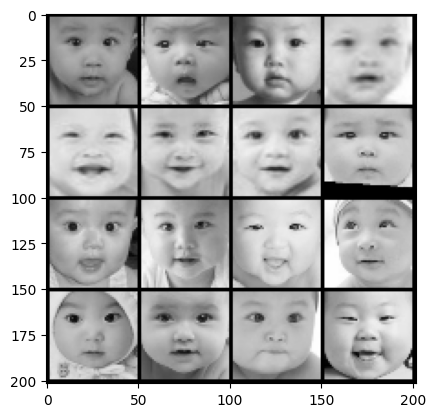

In [8]:
img = image_tensor[:16].detach().cpu()
show_img(img[:16])

In [9]:
class Faces(Dataset):
    def __init__(self, images, transform=False):
        self.transform = transform
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        image /= 255.
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = torch.as_tensor(image, dtype=torch.float32)
        
        return image

In [10]:
root_dir = "age_gender.csv"
transform = transforms.Compose([
    transforms.Normalize(0.5, 0.5),
    transforms.ToTensor()
])
dataset = Faces(images, transform=None)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [11]:
for i in loader:
    print(i)
    break

tensor([[[0.8706, 0.7294, 0.4588,  ..., 0.4353, 0.5294, 0.6431],
         [0.8627, 0.6039, 0.4314,  ..., 0.4235, 0.5608, 0.6275],
         [0.8118, 0.4980, 0.4078,  ..., 0.3451, 0.5059, 0.5922],
         ...,
         [0.6745, 0.1333, 0.4471,  ..., 0.9961, 1.0000, 1.0000],
         [0.7020, 0.4118, 0.4784,  ..., 0.9961, 0.9961, 0.9961],
         [0.6667, 0.5529, 0.4745,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.5176, 0.5373, 0.5529,  ..., 0.0000, 0.0000, 0.0000],
         [0.5294, 0.5490, 0.5569,  ..., 0.0000, 0.0000, 0.0000],
         [0.5333, 0.5451, 0.5216,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7922, 0.7804, 0.8471,  ..., 0.6353, 0.6392, 0.6392],
         [0.8078, 0.7961, 0.8275,  ..., 0.6431, 0.6353, 0.6392],
         [0.8235, 0.8118, 0.8000,  ..., 0.6588, 0.6392, 0.6118]],

        [[0.1490, 0.1176, 0.1098,  ..., 0.0510, 0.0549, 0.0588],
         [0.1059, 0.0824, 0.0706,  ..., 0.0510, 0.0471, 0.0549],
         [0.0627, 0.0784, 0.0706,  ..., 0.0392, 0.0431, 0.

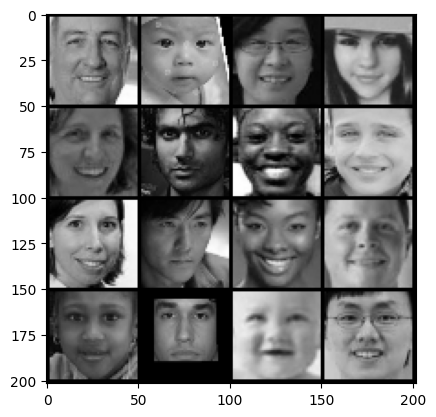

In [12]:
show_img(i.view(-1, 1, 48, 48).detach().cpu())

In [13]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=2304, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_disc_block(im_dim, hidden_dim*4),
            self.get_disc_block(hidden_dim*4, hidden_dim*2),
            self.get_disc_block(hidden_dim*2, hidden_dim),
            nn.Linear(hidden_dim, 1),
        )
    def get_disc_block(self, in_features, out_features):
        return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.LeakyReLU(0.2)
            )
    def forward(self, img):
        return self.disc(img)

In [14]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=128, im_dim=2304):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.get_gen_block(z_dim, hidden_dim),
            self.get_gen_block(hidden_dim, hidden_dim*2),
            self.get_gen_block(hidden_dim*2, hidden_dim*4),
            self.get_gen_block(hidden_dim*4, hidden_dim*8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )

    def get_gen_block(self, in_features, out_features):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(inplace=True)
        )
    def forward(self, noise):
        return self.gen(noise)

In [15]:
z_dim = 64
n_epoch = 5
lr = 3e-4
display_step = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
img_dim = 1*48*48

criterion = nn.BCEWithLogitsLoss()

disc = Discriminator().to(device)
gen = Generator(z_dim=z_dim).to(device)

disc_optim = torch.optim.Adam(disc.parameters(), lr=lr)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr)

  0%|          | 0/1482 [00:00<?, ?it/s]

Step 500: Generator loss: 4.323990091562272, discriminator loss: 0.41558120545744864


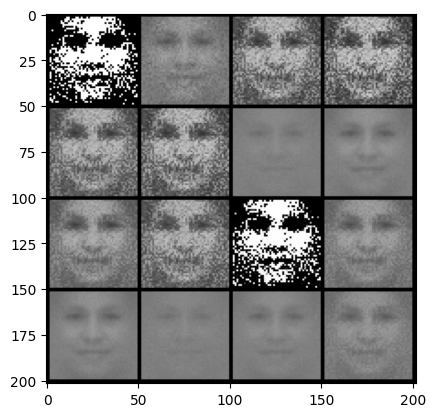

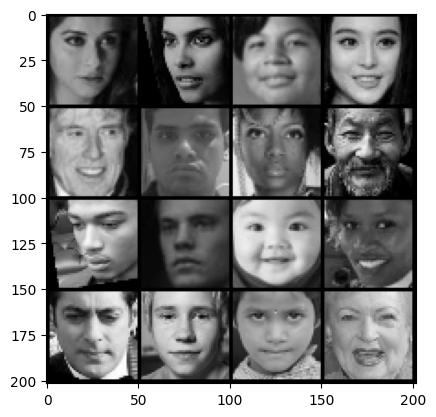

Step 1000: Generator loss: 4.953934730529784, discriminator loss: 0.3413737987130884


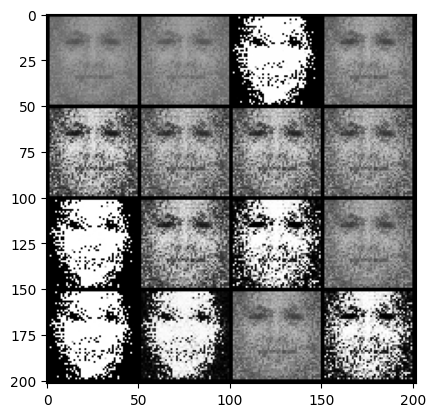

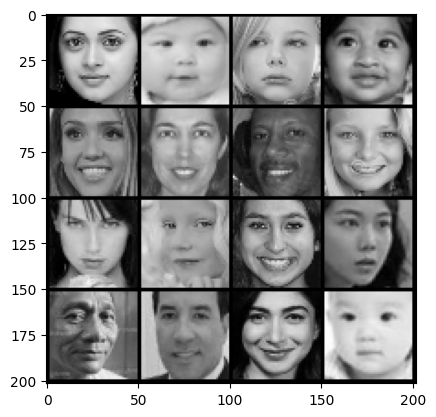

  0%|          | 0/1482 [00:00<?, ?it/s]

Step 1500: Generator loss: 5.841252863168715, discriminator loss: 0.31013649207726096


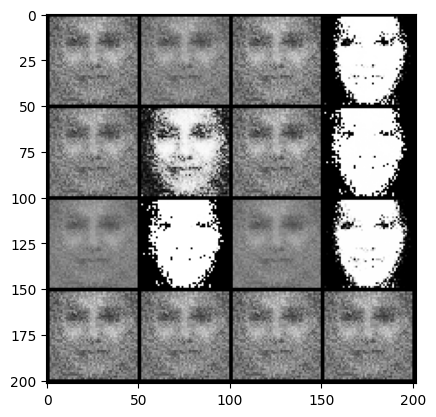

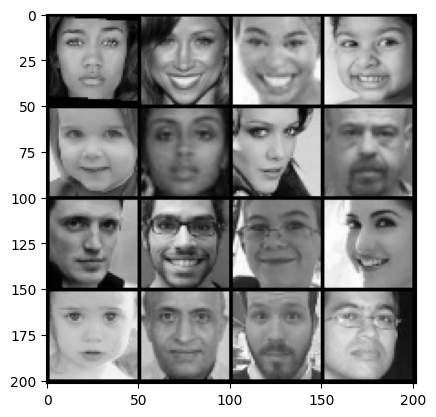

Step 2000: Generator loss: 15.09380612945556, discriminator loss: 0.08109779683640234


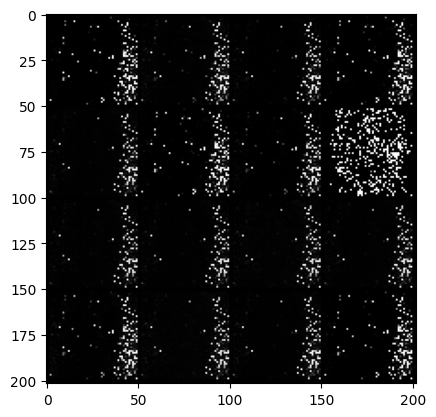

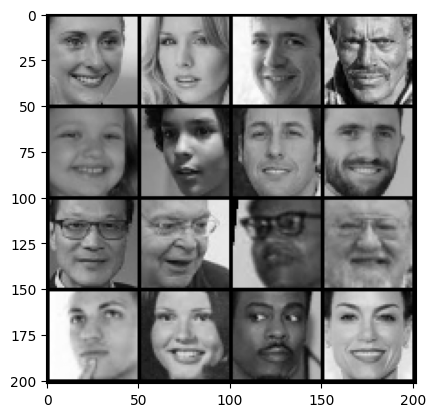

Step 2500: Generator loss: 3.654081894874569, discriminator loss: 0.41750251669576366


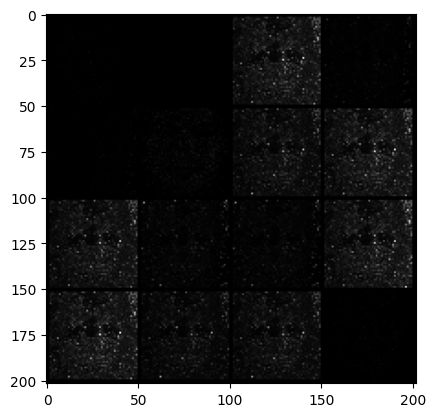

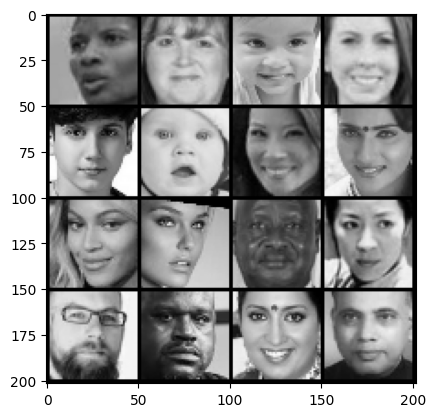

  0%|          | 0/1482 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.5220061810016636, discriminator loss: 0.5156144903898238


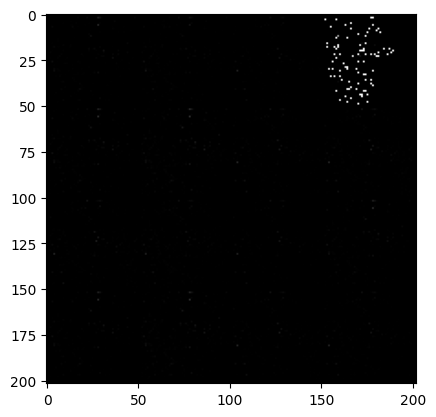

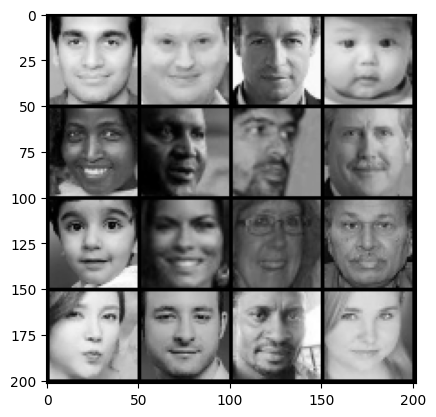

Step 3500: Generator loss: 2.153600448727608, discriminator loss: 0.5795003450810912


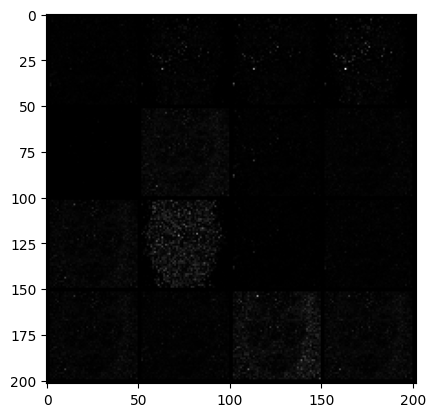

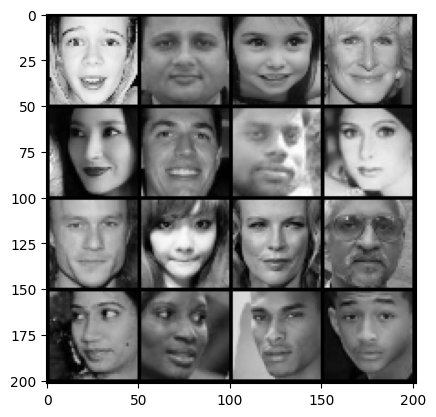

Step 4000: Generator loss: 0.6776137509346007, discriminator loss: 0.7089687763452527


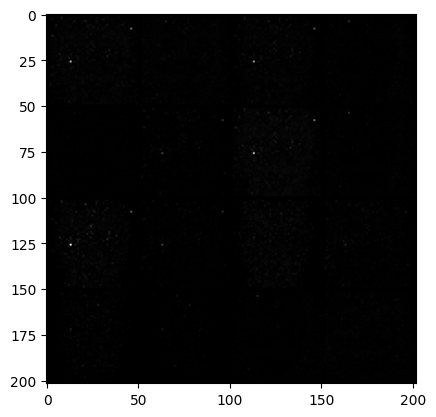

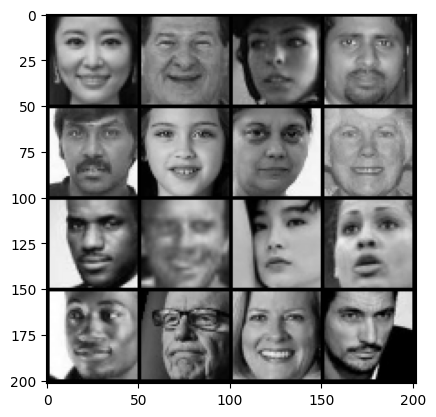

  0%|          | 0/1482 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6784130066633225, discriminator loss: 0.7078350412845618


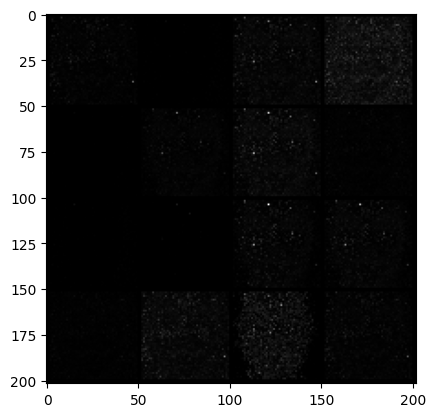

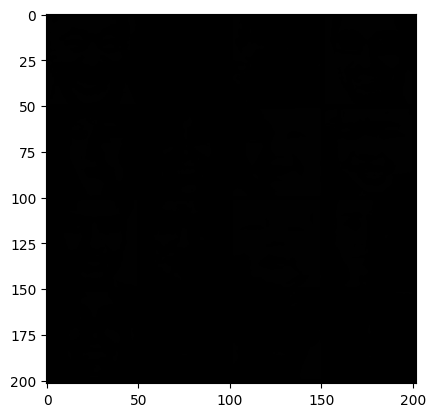

Step 5000: Generator loss: 0.6973726511001589, discriminator loss: 0.6890776576995855


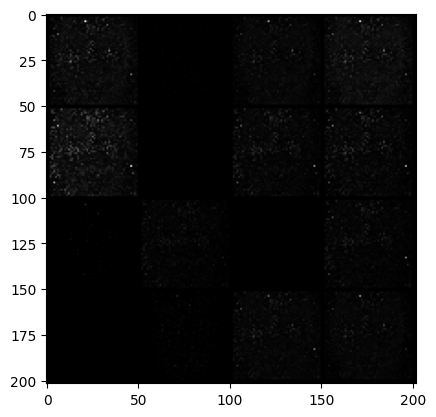

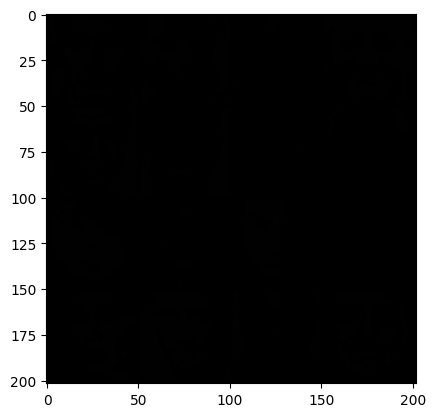

Step 5500: Generator loss: 0.6965177712440497, discriminator loss: 0.6900489906072615


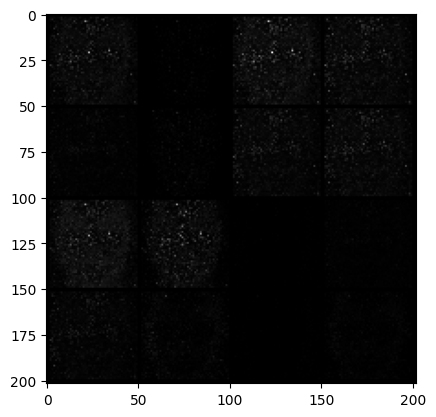

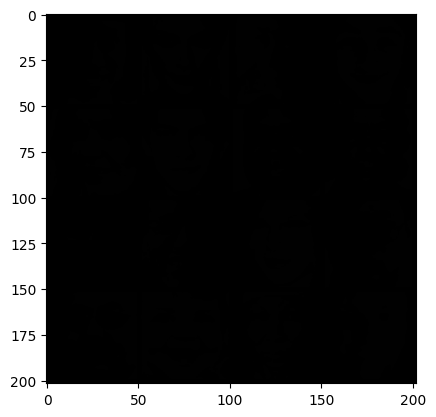

  0%|          | 0/1482 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6954847137928017, discriminator loss: 0.6909896219968787


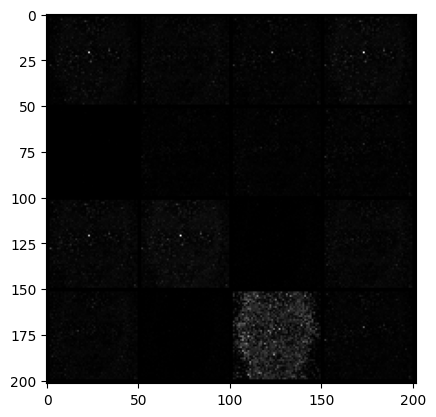

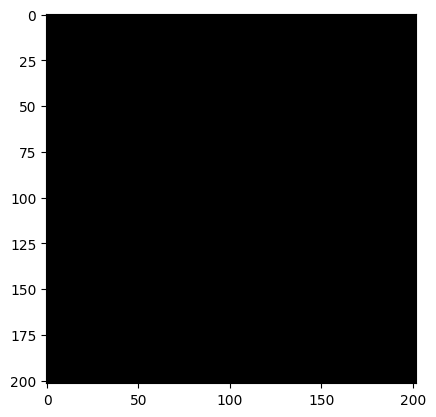

Step 6500: Generator loss: 0.6951415232419967, discriminator loss: 0.6914295099973674


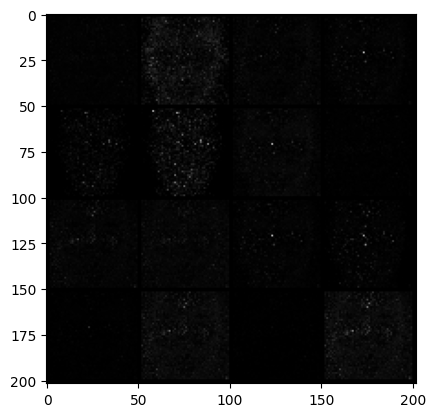

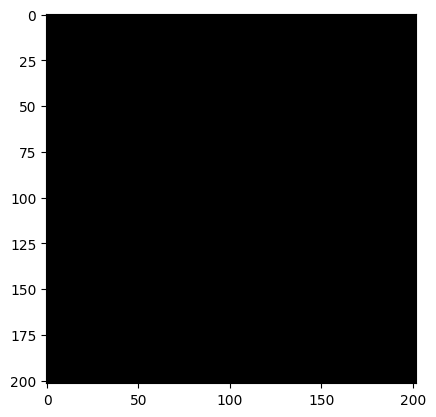

Step 7000: Generator loss: 0.6944937744140625, discriminator loss: 0.6917996320724481


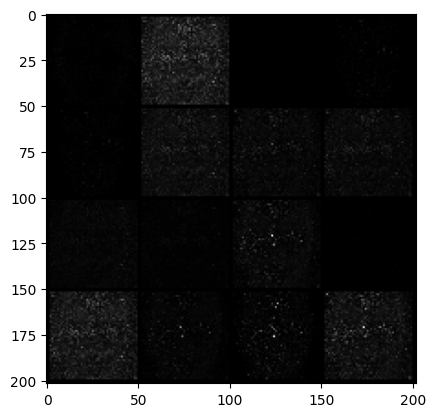

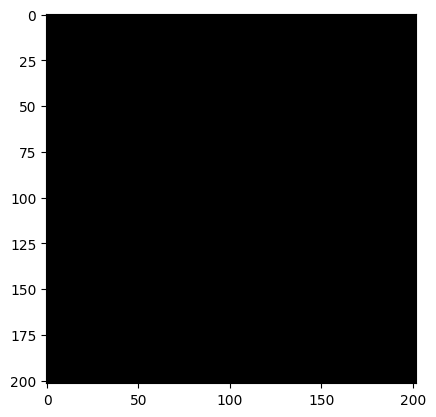

In [16]:
mean_generator_loss = 0
mean_discriminator_loss = 0

step = 0

for epoch in range(n_epoch):

    for real in tqdm(loader):
        cur_batch_size = len(real)

        flattened_image = real.view(cur_batch_size, -1).to(device)
        

        noise = torch.randn((cur_batch_size, z_dim), device=device)


        ###### Train Discriminator
        fake = gen(noise)
        fake_pred = disc(fake.detach())

        fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
        real_pred = disc(flattened_image)

        real_loss = criterion(real_pred, torch.ones_like(real_pred))

        disc_loss = (fake_loss + real_loss) / 2 

        disc_optim.zero_grad()

        disc_loss.backward(retain_graph=True)
        disc_optim.step()



        ###### Train Generator

        noise2 = torch.randn((cur_batch_size, z_dim), device=device)

        fake2 = gen(noise2)

        fake2_pred = disc(fake2)

        gen_loss = criterion(fake2_pred, torch.ones_like(fake2_pred))

        gen_optim.zero_grad()

        gen_loss.backward()
        gen_optim.step()


        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step


        if step % display_step == 0 and step > 0:


            print(f"Step {step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")



            noise_test = torch.randn((cur_batch_size, z_dim), device=device)

            fake = gen(noise_test).view(-1, 1, 48, 48).detach().cpu()

            real = real.view(-1, 1, 48, 48).detach().cpu()
                 

            show_img(fake)

            show_img(real)

            mean_discriminator_loss = 0

            mean_generator_loss = 0


        step+=1   